In [2]:
from model import UNet
from get_data import generate_mall_data, generate_ucsd_data, create_hdf5, loadmat

In [3]:
import torch
import h5py
import numpy as np
from PIL import Image
import shutil
from scipy.io import loadmat
import glob
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from typing import List, Tuple
from matplotlib import pyplot as plt

In [3]:
model = UNet(input_filters=3)

In [17]:
x = torch.rand((1, 3, 256, 256))
y = model(x)

In [18]:
print(y.shape)

torch.Size([1, 1, 256, 256])


In [22]:
generate_mall_data()

In [7]:

with h5py.File('mall/train.h5', "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    b_group_key = list(f.keys())[1]
    print(f['labels'])
    print(f['images'])
    data = list(f[a_group_key])
    labels = list(f[b_group_key])
    

Keys: <KeysViewHDF5 ['images', 'labels']>
<HDF5 dataset "labels": shape (1500, 1, 480, 640), type "<f4">
<HDF5 dataset "images": shape (1500, 3, 480, 640), type "<f4">


In [5]:
paths = []

for name in glob.glob('NWPU/mats/*.mat'):
    paths.append(int(name.replace('NWPU/mats/','').replace('.mat','')))

labels = []
for i in range(1000, 2000):
    labels.append(loadmat('NWPU/mats/'+str(i+1)+'.mat')['annPoints'])

In [11]:
points = labels[0]


In [13]:
im = Image.open('NWPU/images/images_part2/1001.jpg')
w, h = im.size
print(w,h)
img = im.resize((640,480))

4200 2318


In [14]:
new_pts = np.zeros(points.shape)
for i, pt in enumerate(points):
    new_pts[i][0] = pt[0]*(640/w)
    new_pts[i][1] = pt[1]*(480/h)

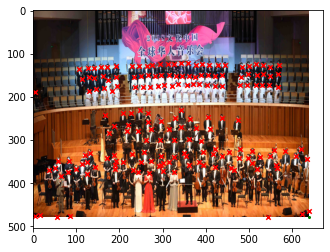

In [15]:
plt.imshow(img)
plt.plot(640, 480, "og", markersize=2)  # og:shorthand for green circle
plt.scatter(new_pts[:,0], new_pts[:,1], marker="x", color="red", s=20)
plt.show()

In [43]:
def generate_label(label_info: np.array, image_shape: List[int]):
    """
    Generate a density map based on objects positions.

    Args:
        label_info: (x, y) objects positions
        image_shape: (width, height) of a density map to be generated

    Returns:
        A density map.
    """
    # create an empty density map
    label = np.zeros(image_shape, dtype=np.float32)
    # loop over objects positions gaussian_filterand marked them with 100 on a label
    # note: *_ because some datasets contain more info except x, y coordinates
    for x, y in label_info:
        if y < image_shape[0] and x < image_shape[1]:
            label[int(y)][int(x)] = 100

    # apply a convolution with a Gaussian kernel
    label = gaussian_filter(label, sigma=(1, 1), order=0)

    return label


In [44]:
def generate_nwpu_data():
    """Generate HDF5 files for mall dataset."""
    # download and extract dataset
    #commented by kc
    # get_and_unzip(
    #     'http://personal.ie.cuhk.edu.hk/~ccloy/files/datasets/mall_dataset.zip'
    # )
    # create training and validation HDF5 files
    train_h5, valid_h5 = create_hdf5('nwpu_dataset',
                                     train_size=1000,
                                     valid_size=0,
                                     img_size=(480, 640),
                                     in_channels=3)

    # load labels infomation from provided MATLAB file
    # it is a numpy array with (x, y) objects position for subsequent frames
    labels = []
    for i in range(1000, 2000):
        labels.append(loadmat('NWPU/mats/'+str(i+1)+'.mat')['annPoints'])

    def fill_h5(h5, labels, init_frame=1000):
        """
        Save images and labels in given HDF5 file.

        Args:
            h5: HDF5 file
            labels: the list of labels
            init_frame: the first frame in given list of labels
        """
        for i, label in enumerate(labels, init_frame):
            # path to the next frame (filename convention: seq_XXXXXX.jpg)
            img_path = f"NWPU/images/images_part2/{str(i+1).zfill(4)}.jpg"

            # get an image as numpy array
            img = cv2.imread(img_path)
            img = img[...,::-1]
            w, h, _ = img.shape
            image = cv2.resize(img,(640,480))
            
 
            image = np.array(image, dtype=np.float32) / 255

            image = np.transpose(image, (2, 0, 1))
            print(image.shape)

            lab = np.zeros(label.shape)
            for j, pt in enumerate(label):
                lab[j][0] = pt[0]*(640/w)
                lab[j][1] = pt[1]*(480/h)

            # generate a density map by applying a Gaussian filter
            label = generate_label(lab, image.shape[1:])

            # save data to HDF5 file
            h5['images'][i - init_frame] = image
            h5['labels'][i - init_frame, 0] = label

    # use first 1500 frames for training and the last 500 for validation
    fill_h5(train_h5, labels)
    # fill_h5(valid_h5, labels[1500:], 1500)

    # close HDF5 file
    train_h5.close()
    # valid_h5.close()

    # cleanup
    # shutil.rmtree('nwpu_dataset')

In [ ]:
generate_nwpu_data()

In [ ]:
with h5py.File('nwpu_dataset/train.h5', 'r') as f:
    print(f.keys())
    print(type(f['images']))
    images = []
    labels = []
    for i in range(len(f['images'])):
        images.append(f['images'][i])
        labels.append(f['labels'][i])
    
    

In [61]:
cv2.imshow('i',images[0].transpose(1,2,0))

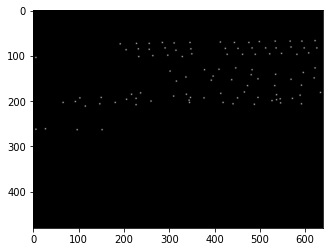

In [59]:
plt.imshow(labels[0][0], cmap="gray")
plt.show()

In [ ]:
print(type(images[0]))
img = images[0].transpose(1,2,0)
print(img.shape)
img = Image.fromarray((img * 255).astype('uint8'))
img.show()
# print(img.shape)

In [42]:
print(labels[0].shape)
label = labels[0].transpose(1,2,0)[:,:,0]
print(label.shape)
lab = Image.fromarray(label, mode='L')
lab.show()

(1, 480, 640)
(480, 640)


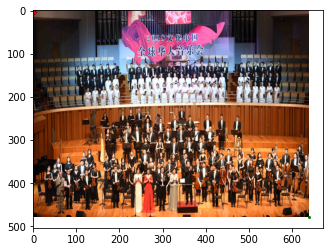

In [124]:
plt.imshow(img)
plt.plot(640, 480, "og", markersize=2)  # og:shorthand for green circle
plt.scatter(label[:, 0], label[:, 1], marker="x", color="red", s=20)
plt.show()

In [ ]:
for item in label:
    cv2.drawMarker(img, (int(item[0]), int(item[1])),(0,0,255), markerType=cv2.MARKER_STAR, 
    markerSize=40, thickness=2, line_type=cv2.LINE_AA)